# Primer Parcial

#### 01-4900 | 2C 2025

*Alumnos* :
*   MARTINEZ CANNELLA, IÑAKI
*   GHIANO, GONZALO AGUSTÍN
*   CHAILE, FACUNDO MARTIN
*   ALAZRAKI, MICAELA AGUSTINA
*   RINAUDO, DIEGO NAHUEL

*Grupo* :
Data y Familia

## Enunciado

La empresa “Business Prop SRL” contrata nuestros servicios para que le desarrollemos un
modelo que permita predecir si los departamentos vendidos pagan o no comisión, cuando su
precio de venta sea superior a un determinado valor.
Para ello, nos comparten un dataset llamado dptos_entrenamiento.csv, que contiene
información de departamentos vendidos en distintos lugares de Argentina y el exterior. Este
dataset será el que utilicemos para el entrenamiento del modelo construido.
El dataset de predicción a utilizar es dptos_predecir.csv, el cual no contiene la etiqueta de la
variable clase (por defecto viene indicada como “no paga”).

## Carga de Librerías

Procedemos a cargar las librerias de Python necesarias para el analisis de los datasets proporcionados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Agregamos modelos de ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer

import os


## Funciones Auxiliares

In [2]:
def boxplotAndHist(na, binwidth=0.5, title = None):
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # assigning a graph to each ax
    sns.boxplot(na, orient="h", ax=ax_box)
    sns.histplot(na, binwidth=binwidth, ax=ax_hist)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    if title is not None:
        plt.title(title)
    plt.show()

In [3]:
#TODO: Funcion de ganancia
#TODO: Boxplot en univariado -Done
#TODO: Heatmap -Done
#TODO: Arbol para ver importancia de las variables
#TODO: PCA
#TODO: Imputar con KNN??????
#TODO: Carpeta 3, nb: 06_prestamos
#TODO: Listar correlacion entre variables y la target

## Lectura de los dataset

In [4]:
df_train = pd.read_csv('datasets/dptos_entrenamiento.csv')

# mostramos para tener una idea de como se ven los datos
print("Datos de Entrenamiento:", df_train.shape)
df_train.head()

Datos de Entrenamiento: (76984, 21)


,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price_period,title,paga_comision
0,RDfa+E7upD0n5pptEfHdMg==,Propiedad,2020-01-08,2020-01-11,2020-01-08,-37.999860,-57.555031,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Venta depto dos ambientes con frente abierto,no paga
1,mL0EoZeEqENVokwugUrtow==,Propiedad,2020-01-17,2020-01-21,2020-01-17,-34.566363,-58.438766,Argentina,Capital Federal,Palermo,...,NaN,NaN,4.0,3.0,1.0,81.0,75.0,NaN,VENTA 4 AMBIENTES C COCHERA FIJA MUY LUMINOSO,paga
2,hOZOY5Bo9FzB3IR8V6TtiA==,Propiedad,2019-11-15,9999-12-31,2019-11-15,-37.106865,-56.862300,Argentina,Buenos Aires Costa Atlántica,Pinamar,...,NaN,NaN,1.0,NaN,1.0,30.0,30.0,NaN,Monoambiente con entrepiso-A 150 mts de Av- Shaw-,no paga
3,JKfw+/BUerJ7cNjors3UBQ==,Propiedad,2019-07-14,9999-12-31,2019-07-14,NaN,NaN,Uruguay,Montevideo,NaN,...,NaN,NaN,3.0,2.0,1.0,62.0,54.0,Mensual,DEPARTAMENTO EN VENTA,no paga
4,SBDKF7R+J2C+n4gWm4JrOw==,Propiedad,2020-02-10,2020-04-28,2020-02-10,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,Departamento 3 ambientes a estrenar. Oportunid...,no paga


## Funcion de Ganancia

In [5]:
## Poner funcion de ganancia aca
# Seguro queremos precision, preguntar

## Análisis Exploratorio

### Vistazo general de las variables

In [6]:
display(df_train.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,76984,76984,RDfa+E7upD0n5pptEfHdMg==,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ad_type,76984,1,Propiedad,76984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,76984,363,2020-01-08,2960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,76984,257,9999-12-31,29793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_on,76984,363,2020-01-08,2960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,67643.0,NaN,NaN,NaN,-34.774702,2.900237,-54.812682,-34.748868,-34.603771,-34.558653,47.545277
lon,67498.0,NaN,NaN,NaN,-58.833661,2.112804,-111.611617,-58.552874,-58.437044,-58.363745,-48.38763
l1,76984,4,Argentina,74447,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l2,76984,31,Capital Federal,32608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l3,72486,294,Mar del Plata,9735,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analisis de Tipo de Dato

Analizamos los tipos de dato del dataset para verificar que no existan columnas innecesariamente de tipo object

In [7]:
df_train.dtypes

id                  object
ad_type             object
start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
l4                  object
l5                  object
l6                 float64
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price_period        object
title               object
paga_comision       object
dtype: object

Aplicamos conversiones de tipo de datos para asegurarnos de tener el tipo mas apropiado

In [8]:
"""
colToStr = ['title', 'ad_type', 'price_period', 'paga_comision', 'id', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'lat', 'lon']
for col in colToStr:
    df_train[col] = df_train[col].astype(str)

df_train['surface_covered'] = df_train['surface_covered'].astype('Int64')
df_train['rooms'] = df_train['rooms'].astype('Int64')
df_train['bedrooms'] = df_train['bedrooms'].astype('Int64')
df_train['bathrooms'] = df_train['bathrooms'].astype('Int64')
df_train['surface_total'] = df_train['surface_total'].astype('Int64')
"""
#las fechas hay que convertirlas a otro tipo?

"\ncolToStr = ['title', 'ad_type', 'price_period', 'paga_comision', 'id', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'lat', 'lon']\nfor col in colToStr:\n    df_train[col] = df_train[col].astype(str)\n\ndf_train['surface_covered'] = df_train['surface_covered'].astype('Int64')\ndf_train['rooms'] = df_train['rooms'].astype('Int64')\ndf_train['bedrooms'] = df_train['bedrooms'].astype('Int64')\ndf_train['bathrooms'] = df_train['bathrooms'].astype('Int64')\ndf_train['surface_total'] = df_train['surface_total'].astype('Int64')\n"

# Verificacion de Duplicados

Observamos que no hay duplicados en nuestro set de datos

In [9]:
print("Cantidad original:", df_train.shape)
df_train.drop_duplicates(inplace =True)
print("Cantidad sin duplicados:", df_train.shape)

Cantidad original: (76984, 21)
Cantidad sin duplicados: (76984, 21)


# Analizando Variables Predictoras

Analisis univariado de las columnas de nuestro dataset para comprender elementos subyacentes del mismo y verificar su utilidad

id - Id del anuncio

Conclusion - No posee nulos ni repetidos, apta para usarla como indice del dataset

In [10]:
df_train.set_index('id', inplace=True)

In [11]:
variables_a_eliminar = []

ad_type - Tipo de propiedad anunciada

Conclusion - Posee un unico valor en todo nuestro dataset. La misma no aporta ningun valor predictivo, por lo que procedemos a eliminarla

In [12]:
print(df_train["ad_type"].dtype)
print(df_train["ad_type"].unique())

variables_a_eliminar.append("ad_type")

object
['Propiedad']


start_date - Fecha en la que la propiedad comenzo a estar disponible

Conclusion - La descartamos inicialmente por ser de tipo fecha

In [13]:
## Preguntar en clase, por ahora vacio
# con la resta end - start podemos ver cuanto tardo en venderse
dtype = df_train["start_date"].dtype
row_count = df_train["start_date"].count()
null_count = df_train["start_date"].isnull().sum()
unique = df_train["start_date"].unique()

print("Variable: start_date")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

start_date_counts = df_train['start_date'].value_counts().sort_index()

variables_a_eliminar.append("start_date")

Variable: start_date
Tipo de dato: object
Row count: 76984
Null count: 0


end_date - Fecha en que la propiedad dejo de estar disponible

Conclusion - La descartamos inicialmente por ser de tipo fecha

Variable: end_date
Tipo de dato: object
Row count: 76984
Null count: 0


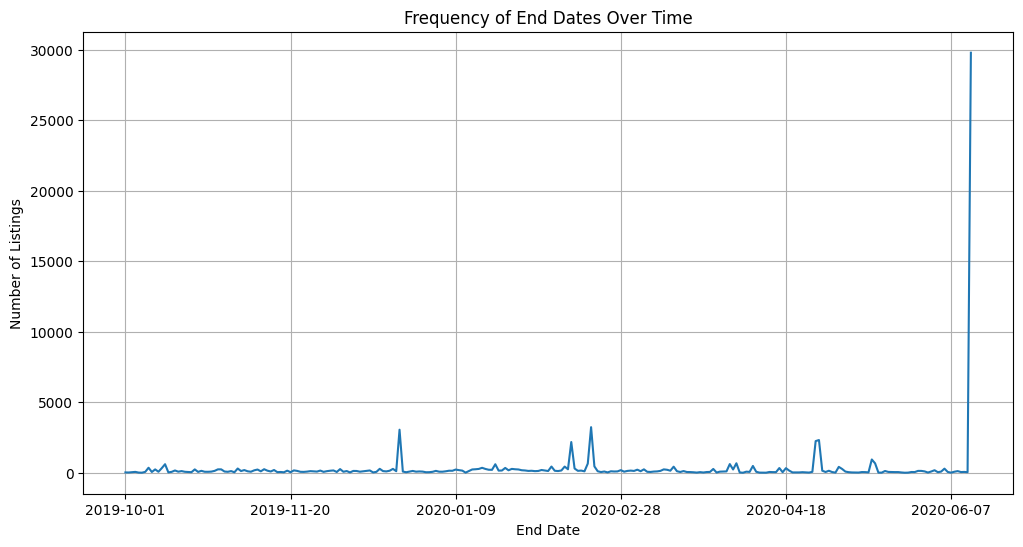

In [14]:
## Preguntar en clase, por ahora vacio
dtype = df_train["end_date"].dtype
row_count = df_train["end_date"].count()
null_count = df_train["end_date"].isnull().sum()
unique = df_train["end_date"].unique()

print("Variable: end_date")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

end_date_counts = df_train['end_date'].value_counts().sort_index()

#Creacion de serie de tiempo para analizar la distribucion
plt.figure(figsize=(12, 6))
end_date_counts.plot()
plt.title('Frequency of End Dates Over Time')
plt.xlabel('End Date')
plt.ylabel('Number of Listings')
plt.grid(True)
plt.show()

variables_a_eliminar.append("end_date")

created_on - Fecha en la que se creo el anuncio de la propiedad

Conclusion - Proporciona la misma informacion que start_date. La eliminamos para evitar redundancias en los datos

In [15]:
# Printeamos cantidad de registros cuya start_date sea distinta de created_on
print(df_train.loc[df_train["created_on"] != df_train["start_date"]]["created_on"].count())

variables_a_eliminar.append("created_on")

0


l1 - Pais donde esta ubicada la propiedad

Conclusion - Posee informacion geografica que puede ser util para nuestro modelo predictivo

Variable: l1
Tipo de dato: object
Row count: 76984
Null count: 0
Valores únicos
['Argentina' 'Uruguay' 'Estados Unidos' 'Brasil']


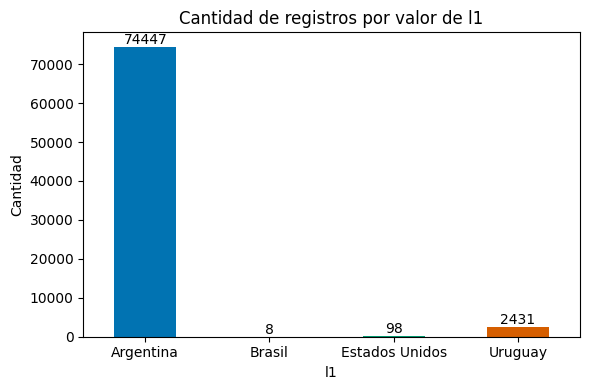

In [16]:
dtype = df_train["l1"].dtype
row_count = df_train["l1"].count()
null_count = df_train["l1"].isnull().sum()
unique = df_train["l1"].unique()

print("Variable: l1")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")
print("Valores únicos")
print(unique)

counts_l1 = df_train['l1'].value_counts().sort_index()
palette_l1 = sns.color_palette("colorblind", n_colors=len(counts_l1))

fig, ax = plt.subplots(figsize=(6, 4))
counts_l1.plot(kind='bar', ax=ax, color=palette_l1)
ax.set_title("Cantidad de registros por valor de l1")
ax.set_xlabel('l1')
ax.set_ylabel('Cantidad')
ax.tick_params(axis='x', rotation=0)
ax.bar_label(ax.containers[0], fmt='%d')
plt.tight_layout()
plt.show()

l2 - Provincia donde esta ubicada la propiedad

Conclusion - Idem l1

Variable: l2
Tipo de dato: object
Row count: 76984
Null count: 0
Valores únicos
['Buenos Aires Costa Atlántica' 'Capital Federal' 'Montevideo'
 'Bs.As. G.B.A. Zona Norte' 'Bs.As. G.B.A. Zona Sur' 'Córdoba' 'Santa Fe'
 'Maldonado' 'Bs.As. G.B.A. Zona Oeste' 'Mendoza' 'Buenos Aires Interior'
 'Neuquén' 'Canelones' 'Tucumán' 'Entre Ríos' 'Florida' 'Catamarca'
 'Río Negro' 'Misiones' 'Jujuy' 'La Pampa' 'Colonia' 'Miami' 'Chaco'
 'Santa Catarina' 'Salta' 'Corrientes' 'Chubut' 'San Juan' 'San Luis'
 'Tierra Del Fuego']


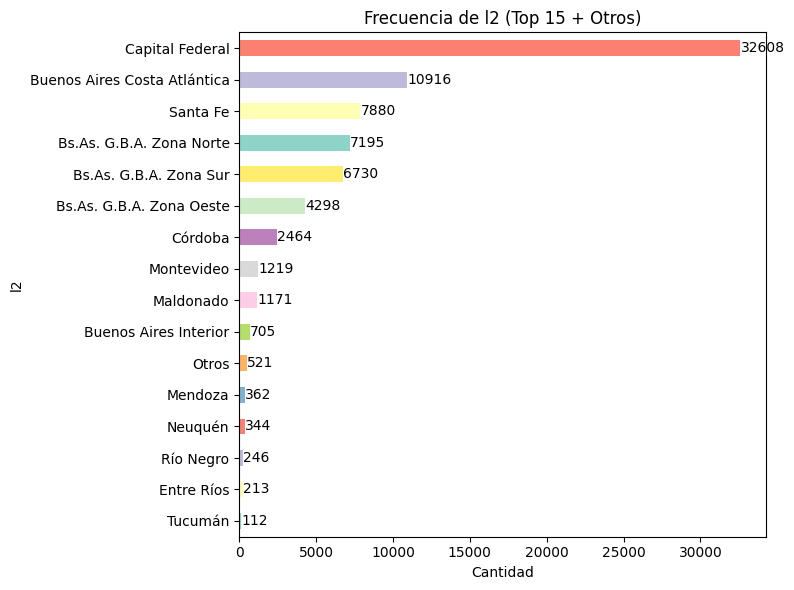

In [17]:
dtype = df_train["l2"].dtype
row_count = df_train["l2"].count()
null_count = df_train["l2"].isnull().sum()
unique = df_train["l2"].unique()

print("Variable: l2")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")
print("Valores únicos")
print(unique)

top_n = 15  # Veremos solo el top 15 de Región, Zona o Provincia (L2)
counts_l2 = df_train['l2'].value_counts()

top_counts = counts_l2.head(top_n)
other_count = counts_l2.iloc[top_n:].sum()
if other_count > 0:
    top_counts = pd.concat([top_counts, pd.Series({'Otros': other_count})])

colors = list(plt.cm.Set3.colors[:len(top_counts)])

fig, ax = plt.subplots(figsize=(8, 6))
top_counts.sort_values().plot(kind='barh', ax=ax, color=colors)
ax.set_title(f"Frecuencia de l2 (Top {top_n} + Otros)")
ax.set_xlabel('Cantidad')
ax.set_ylabel('l2')
ax.bar_label(ax.containers[0], fmt='%d')
plt.tight_layout()
plt.show()

l3 - Partido donde se ubica la propiedad

Conclusion - Aunque puede otorgarnos datos utiles como l1 y l2, su gran variedad de valores y su cantidad de nulos respecto al total del dataset indican que puede descartarse del analisis inicial

Variable: l3
Tipo de dato: object
Row count: 72486
Null count: 4498
Valores únicos: 295


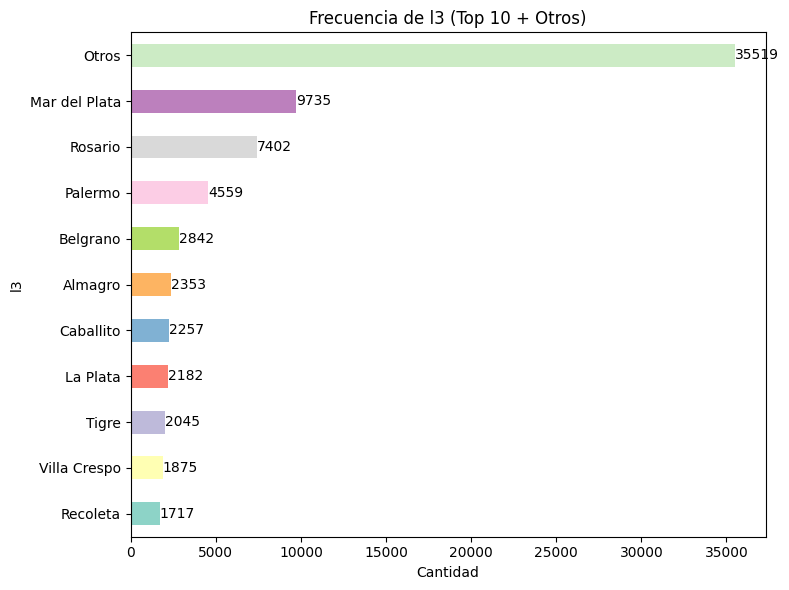

In [18]:
dtype = df_train["l3"].dtype
row_count = df_train["l3"].count()
null_count = df_train["l3"].isnull().sum()
unique_count = len(df_train["l3"].unique())

print("Variable: l3")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")
print(f"Valores únicos: {unique_count}")


top_n = 10 
counts_l3 = df_train['l3'].value_counts()

top_counts = counts_l3.head(top_n)
other_count = counts_l3.iloc[top_n:].sum()
if other_count > 0:
    top_counts = pd.concat([top_counts, pd.Series({'Otros': other_count})])

colors = list(plt.cm.Set3.colors[:len(top_counts)])

fig, ax = plt.subplots(figsize=(8, 6))
top_counts.sort_values().plot(kind='barh', ax=ax, color=colors)
ax.set_title(f"Frecuencia de l3 (Top {top_n} + Otros)")
ax.set_xlabel('Cantidad')
ax.set_ylabel('l3')
ax.bar_label(ax.containers[0], fmt='%d')
plt.tight_layout()
plt.show()

De los 295 valores que puede tomar la variable, 57 aparecen solo una vez.</br>
Ademas, es una columna con alta cardinalidad así que la vamos a sacar por ahora.

In [19]:
l3_count = df_train.groupby('l3').size().reset_index(name='count')
print(l3_count.loc[l3_count["count"] < 2].count())

variables_a_eliminar.append("l3")

l3       57
count    57
dtype: int64


l4, l5 y l6 - Ciudad/Barrio donde esta ubicada la propiedad

Conclusion - Luego de l3, las variables poseen muy pocos datos en comparacion al total de la muestra. Se procede a eliminar l4, l5 y l6.

In [20]:
l4_row_count = df_train["l4"].count()
l5_row_count = df_train["l5"].count()
l6_row_count = df_train["l6"].count()

print(f"Conteo l4: {l4_row_count}")
print(f"Conteo l5: {l5_row_count}")
print(f"Conteo l6: {l6_row_count}")

# Row count muy bajo, las eliminamos
variables_a_eliminar.append("l4")
variables_a_eliminar.append("l5")
variables_a_eliminar.append("l6")

Conteo l4: 14777
Conteo l5: 159
Conteo l6: 0


lat - Coordenada de latitud de la propiedad

Conclusion - Lat y Lon nos otorga informacion que ya podiamos obtener con l1 y l2.

In [21]:
dtype = df_train["lat"].dtype
row_count = df_train["lat"].count()
null_count = df_train["lat"].isnull().sum()

print("Variable: lat")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

variables_a_eliminar.append("lat")

Variable: lat
Tipo de dato: float64
Row count: 67643
Null count: 9341


Lon - Coordenada de longitud de la propiedad

Conclusion - Idem Lat

In [22]:
dtype = df_train["lon"].dtype
row_count = df_train["lon"].count()
null_count = df_train["lon"].isnull().sum()

print("Variable: lon")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

variables_a_eliminar.append("lon")

Variable: lon
Tipo de dato: float64
Row count: 67498
Null count: 9486


rooms - Cantidad de habitaciones de la propiedad

Conclusion - Pareciera tener un valor predictivo importante. Podría haber outilers, lo vamos a ver más adelante.

Variable: rooms
Tipo de dato: float64
Row count: 59968
Null count: 17016


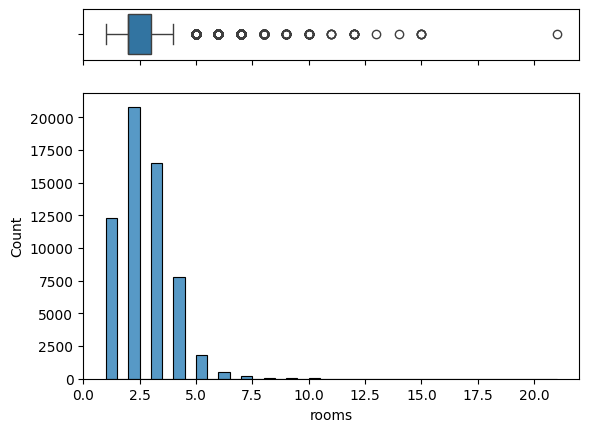

In [23]:
dtype = df_train["rooms"].dtype
row_count = df_train["rooms"].count()
null_count = df_train["rooms"].isnull().sum()

print("Variable: rooms")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

boxplotAndHist(df_train["rooms"])

bedrooms - Cantidad de dormitorios de la propiedad



Conclusion - Tiene muchos outliers.

Variable: bedrooms
Tipo de dato: float64
Row count: 38049
Null count: 38935


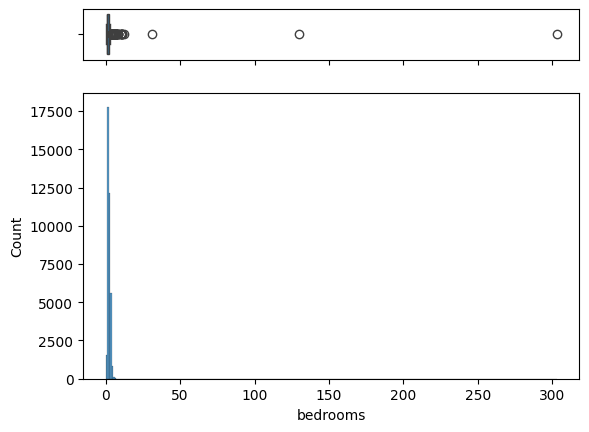

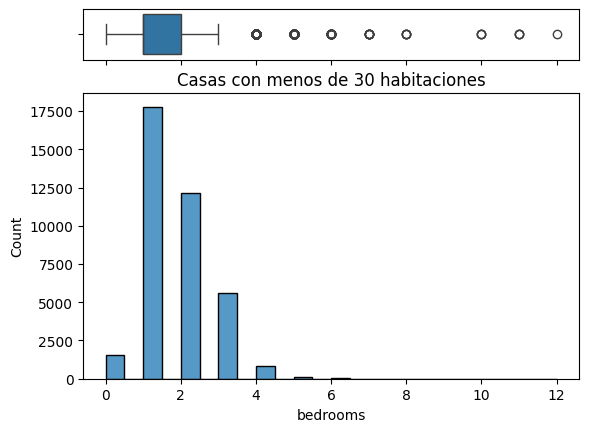

In [24]:
dtype = df_train["bedrooms"].dtype
row_count = df_train["bedrooms"].count()
null_count = df_train["bedrooms"].isnull().sum()

print("Variable: bedrooms")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

boxplotAndHist(df_train["bedrooms"], binwidth = 1)

# Mostramos casas con menos de 30 habitaciones para ver la distribucion de la mayoría de los casos
less_than_30_bedrooms = df_train.loc[df_train["bedrooms"] < 30]["bedrooms"]
boxplotAndHist(less_than_30_bedrooms, title = "Casas con menos de 30 habitaciones")



bathrooms - Cantidad de banos de la propiedad

Conclusion - Puede tener poder predictivo, seguro hay outliers, los analizamos luegos.

Variable: bathrooms
Tipo de dato: float64
Row count: 71826
Null count: 5158


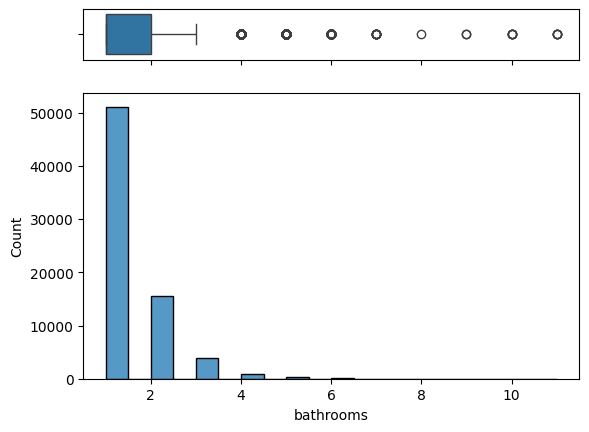

In [25]:
dtype = df_train["bathrooms"].dtype
row_count = df_train["bathrooms"].count()
null_count = df_train["bathrooms"].isnull().sum()

print("Variable: bathrooms")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

## Pocos nulos, tendrá poder predictivo? Por ahora la mantenemos.
## Podemos cambiar el tipo a INT
df_train['bathrooms'] = df_train['bathrooms'].astype('Int64')

boxplotAndHist(df_train["bathrooms"])

surface_total - Superficie total de la propiedad (en metros cuadrados)

Conclusion - Puede tener poder predictivo. Decidimos mantenerla por el momento

In [26]:
dtype = df_train["surface_total"].dtype
row_count = df_train["surface_total"].count()
null_count = df_train["surface_total"].isnull().sum()

print("Variable: surface_total")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

# Es un float64, tiene valores decimales?
valores_no_nulos = df_train["surface_total"].dropna()
cantidad_decimales = (valores_no_nulos % 1 != 0).sum()
print(f"Cantidad de registros con decimales: {cantidad_decimales}")

Variable: surface_total
Tipo de dato: float64
Row count: 43049
Null count: 33935
Cantidad de registros con decimales: 0


surface_covered - Superficie total cubierta de la propiedad (en metros cuadrados)

Conclusion - Puede tener poder predictivo. Decidimos mantenerla por el momento

In [27]:
dtype = df_train["surface_covered"].dtype
row_count = df_train["surface_covered"].count()
null_count = df_train["surface_covered"].isnull().sum()

print("Variable: surface_covered")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")

# Es un float64, tiene valores decimales?
valores_no_nulos = df_train["surface_covered"].dropna()
cantidad_decimales = (valores_no_nulos % 1 != 0).sum()
print(f"Cantidad de registros con decimales: {cantidad_decimales}")

Variable: surface_covered
Tipo de dato: float64
Row count: 45717
Null count: 31267
Cantidad de registros con decimales: 0


In [28]:
"""
nulos_en_total_y_covered_surface = len(df_train.loc[(df_train["surface_covered"].isnull()) & (df_train["surface_total"].isnull())].index)
no_nulos_en_total_y_covered_surface = len(df_train.loc[(df_train["surface_covered"].notnull()) & (df_train["surface_total"].notnull())].index)

print(f"Registros con ambos tipos de superficies nulas: {nulos_en_total_y_covered_surface}")
print(f"Registros con ambos tipos de superficies no nulas: {no_nulos_en_total_y_covered_surface}")
len(df_train.index) - (nulos_en_total_y_covered_surface + no_nulos_en_total_y_covered_surface)
"""


'\nnulos_en_total_y_covered_surface = len(df_train.loc[(df_train["surface_covered"].isnull()) & (df_train["surface_total"].isnull())].index)\nno_nulos_en_total_y_covered_surface = len(df_train.loc[(df_train["surface_covered"].notnull()) & (df_train["surface_total"].notnull())].index)\n\nprint(f"Registros con ambos tipos de superficies nulas: {nulos_en_total_y_covered_surface}")\nprint(f"Registros con ambos tipos de superficies no nulas: {no_nulos_en_total_y_covered_surface}")\nlen(df_train.index) - (nulos_en_total_y_covered_surface + no_nulos_en_total_y_covered_surface)\n'

price_period - Periodo en el que se cobrara el precio del anuncio

Conclusion - Los unicos valores que se presentan son mensuales o nulos.  
Creamos una columna que represente si price_period es nulo

In [29]:
dtype = df_train["price_period"].dtype
row_count = df_train["price_period"].count()
null_count = df_train["price_period"].isnull().sum()

print("Variable: price_period")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")
print(df_train["price_period"].unique())

df_train["is_price_period_null"] = df_train["price_period"].isnull().astype(int)
variables_a_eliminar.append("price_period")

Variable: price_period
Tipo de dato: object
Row count: 25755
Null count: 51229
[nan 'Mensual']


Analizamos si is_price_period_null tiene poder predictivo.  
Obtuvimos una diferencia de 5 punto porcentuales respecto a las propiedades que pagan comision cuando el valor es nulo.  
Se debe extender el analisis pero por ahora la consideramos.

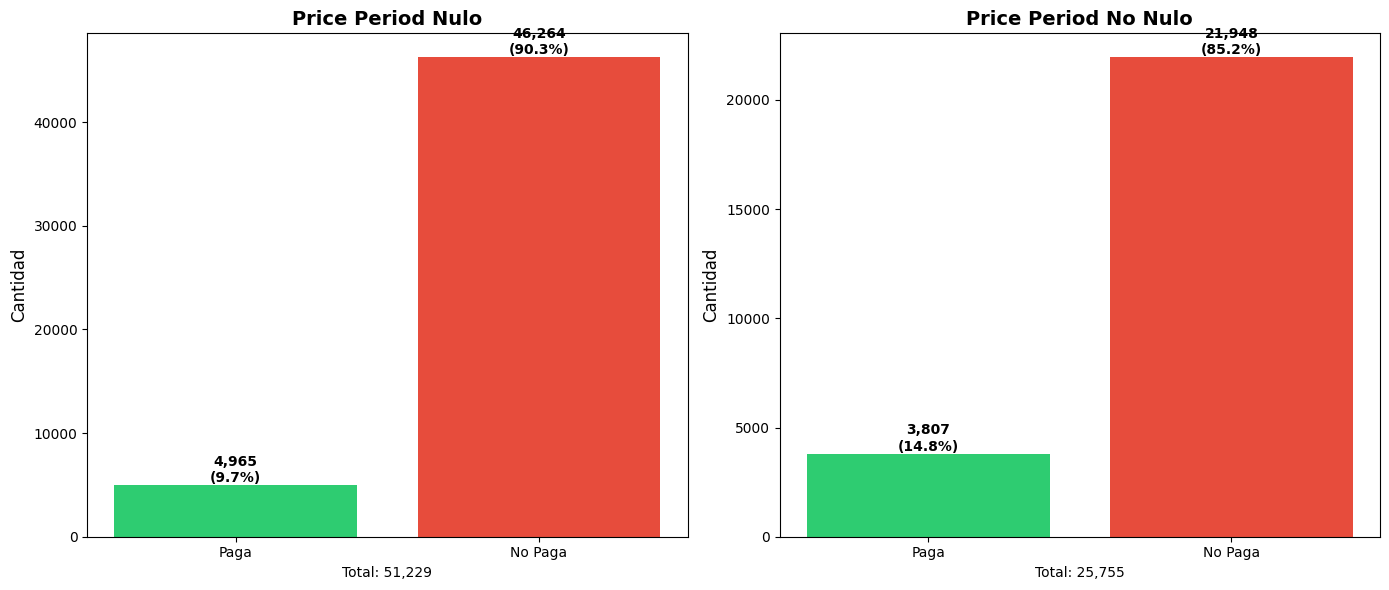

In [30]:
price_period_nulo_paga = len(df_train.loc[(df_train["is_price_period_null"] == 1) & (df_train["paga_comision"] == "paga")].index)
price_period_nulo_no_paga = len(df_train.loc[(df_train["is_price_period_null"] == 1) & (df_train["paga_comision"] == "no paga")].index)
price_period_no_nulo_paga = len(df_train.loc[(df_train["is_price_period_null"] == 0) & (df_train["paga_comision"] == "paga")].index)
price_period_no_nulo_no_paga = len(df_train.loc[(df_train["is_price_period_null"] == 0) & (df_train["paga_comision"] == "no paga")].index)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Price Period Nulo
categorias_nulo = ['Paga', 'No Paga']
valores_nulo = [price_period_nulo_paga, price_period_nulo_no_paga]
total_nulo = sum(valores_nulo)
proporciones_nulo = [v/total_nulo * 100 for v in valores_nulo]

axes[0].bar(categorias_nulo, valores_nulo, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Price Period Nulo', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cantidad', fontsize=12)
axes[0].set_xlabel(f'Total: {total_nulo:,}', fontsize=10)

# Agregar etiquetas con valores y porcentajes
for i, (v, p) in enumerate(zip(valores_nulo, proporciones_nulo)):
    axes[0].text(i, v, f'{v:,}\n({p:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Price Period No Nulo
categorias_no_nulo = ['Paga', 'No Paga']
valores_no_nulo = [price_period_no_nulo_paga, price_period_no_nulo_no_paga]
total_no_nulo = sum(valores_no_nulo)
proporciones_no_nulo = [v/total_no_nulo * 100 for v in valores_no_nulo]

axes[1].bar(categorias_no_nulo, valores_no_nulo, color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Price Period No Nulo', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cantidad', fontsize=12)
axes[1].set_xlabel(f'Total: {total_no_nulo:,}', fontsize=10)

# Agregar etiquetas con valores y porcentajes
for i, (v, p) in enumerate(zip(valores_no_nulo, proporciones_no_nulo)):
    axes[1].text(i, v, f'{v:,}\n({p:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

title - Titulo del anuncio de la propiedad

Conclusion - No pareciera tener ningun poder predictivo, por lo que la eliminamos de nuestro dataset

In [31]:
dtype = df_train["title"].dtype
row_count = df_train["title"].count()
null_count = df_train["title"].isnull().sum()

print("Variable: price_period")
print(f"Tipo de dato: {dtype}")
print(f"Row count: {row_count}")
print(f"Null count: {null_count}")
print(df_train["title"].unique())

## Es el titulo de la publicacion, no hay poder predictivo
variables_a_eliminar.append("title")

Variable: price_period
Tipo de dato: object
Row count: 76984
Null count: 0
['Venta depto dos ambientes con frente abierto'
 'VENTA 4 AMBIENTES C COCHERA FIJA MUY LUMINOSO'
 'Monoambiente con entrepiso-A 150 mts de Av- Shaw-' ...
 'Alsina  800 - U$D 95.000 - Departamento en Venta'
 'VENTA DEPARTAMENTO+LOFT 4 AMBIENTE EN MUÑIZ'
 'RETASADO!!! VENTA 3 AMB Exclusiva zona La Imprenta &amp; Cañitas-Frente-Balcón-Cochera ']


### Variable Target

La clase paga, representa un poco mas de un 11% del total de nuestros datos.  
La diferencia de proporciones no es suficiente como para considerar las clases como desbalanceadas.

In [32]:
# Oversampling? Undersampling?

pagan = df_train.loc[df_train["paga_comision"] == "paga"]["paga_comision"].count()
no_pagan = df_train.loc[df_train["paga_comision"] == "no paga"]["paga_comision"].count()
print(f"Paga: {pagan}")
print(f"No Paga: {no_pagan}")

Paga: 8772
No Paga: 68212


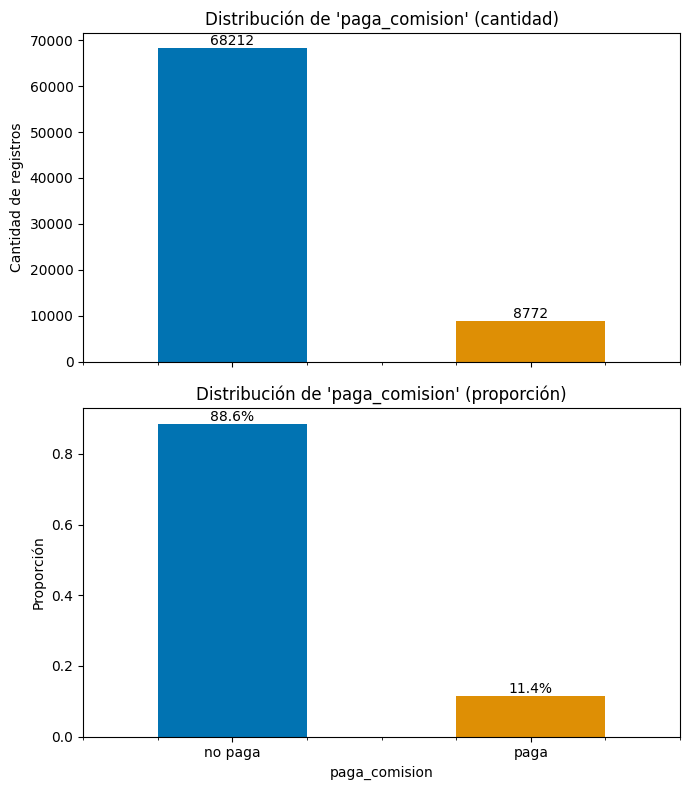

In [33]:
counts = df_train['paga_comision'].value_counts()
props = df_train['paga_comision'].value_counts(normalize=True)
palette = sns.color_palette("colorblind", n_colors=2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

counts.plot(kind='bar', ax=ax1, color=palette)
ax1.set_title("Distribución de 'paga_comision' (cantidad)")
ax1.set_ylabel('Cantidad de registros')
ax1.tick_params(axis='x', rotation=0)
ax1.bar_label(ax1.containers[0], fmt='%d')

props.plot(kind='bar', ax=ax2, color=palette)
ax2.set_title("Distribución de 'paga_comision' (proporción)")
ax2.set_xlabel('paga_comision')
ax2.set_ylabel('Proporción')
ax2.tick_params(axis='x', rotation=0)
ax2.bar_label(ax2.containers[0], fmt='{:.1%}')

plt.tight_layout()
plt.show()

In [34]:
#df_train = df_train.drop(columns=variables_a_eliminar)
print(df_train.columns)

Index(['ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1',
       'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price_period', 'title',
       'paga_comision', 'is_price_period_null'],
      dtype='object')


# Analisis de nulos

In [35]:
variables_a_utilizar = [i for i in df_train.columns if i not in variables_a_eliminar]

In [36]:
variables_a_utilizar

['l1',
 'l2',
 'rooms',
 'bedrooms',
 'bathrooms',
 'surface_total',
 'surface_covered',
 'paga_comision',
 'is_price_period_null']

In [37]:
variables_a_utilizar_numericas = ['rooms','bedrooms','bathrooms','surface_total','surface_covered', 'paga_comision']

Vamos a analizar si podemos imputar nulos, usamos la matriz de correlación para ver la relacion entre las variables.

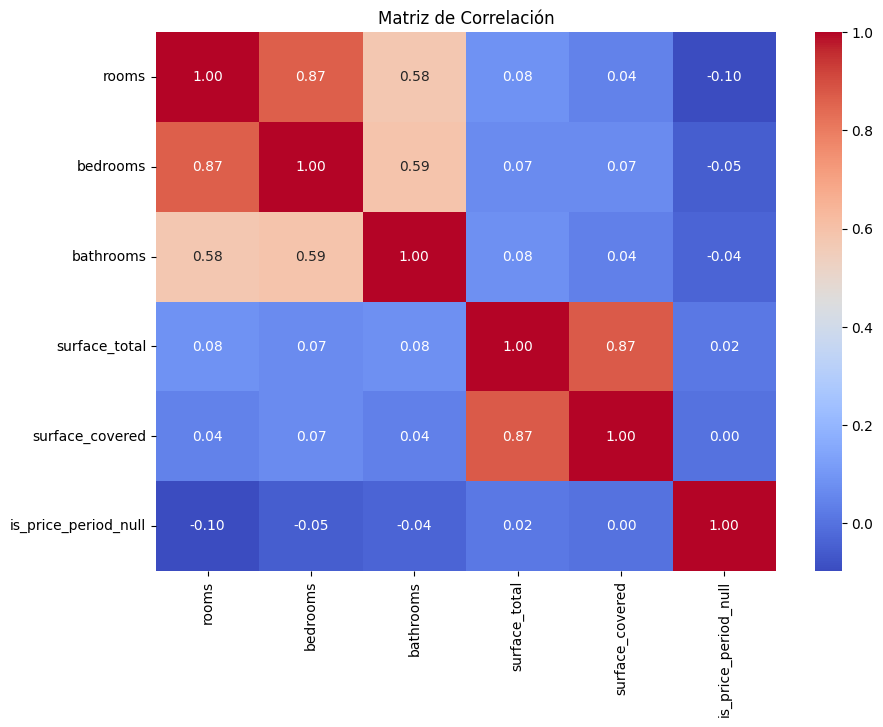

In [38]:
fig, ax = plt.subplots(figsize=(10,7))
mat = df_train[variables_a_utilizar].select_dtypes(include=['int', 'float']).corr()
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f",  ax=ax)
plt.title('Matriz de Correlación')
plt.show()

In [39]:
df_train[variables_a_utilizar].isnull().sum()

l1                          0
l2                          0
rooms                   17016
bedrooms                38935
bathrooms                5158
surface_total           33935
surface_covered         31267
paga_comision               0
is_price_period_null        0
dtype: int64

Conclusiones:  
- Podemos imputar rooms usando KNN.
- Debemos considerar si eliminar bedrooms por su alta correlacion con rooms.
- Podemos imputar surface_total usando KNN.
- Debemos considerar si eliminar surface_covered por su alta correlacion con surface_total.

## Analisis de Outliers

In [40]:
def analizar_outliers(col):
    # Detectar outliers con IQR
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    outliers = df_train[(df_train[col] < limite_inferior) | (df_train[col] > limite_superior)][col]
    print(f"Outliers detectados en {col} (IQR): {len(outliers)} ({len(outliers)/len(df_train)*100:.2f}%)\nLimite inferior: {limite_inferior}\nLimite Superior: {limite_superior}")
    #boxplotAndHist(df_train[col])
    df_train[[col]].boxplot()
    plt.show()

l1
object
l2
object
rooms
float64
Outliers detectados en rooms (IQR): 2604 (3.38%)
Limite inferior: 0.5
Limite Superior: 4.5


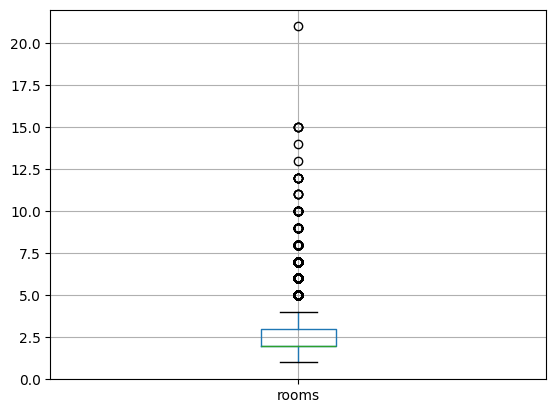

bedrooms
float64
Outliers detectados en bedrooms (IQR): 1000 (1.30%)
Limite inferior: -0.5
Limite Superior: 3.5


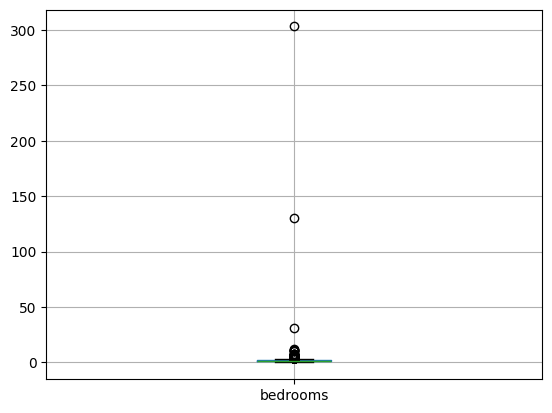

bathrooms
Int64
surface_total
float64
Outliers detectados en surface_total (IQR): 3114 (4.04%)
Limite inferior: -26.0
Limite Superior: 158.0


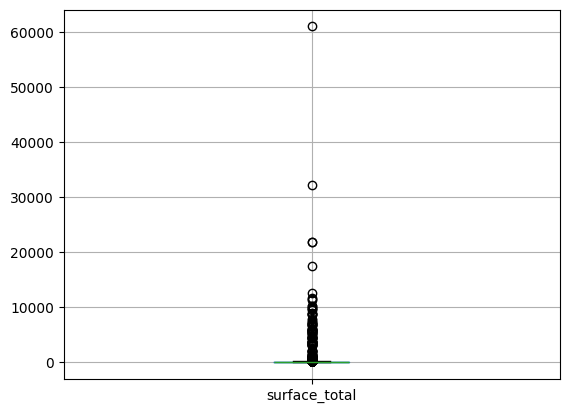

surface_covered
float64
Outliers detectados en surface_covered (IQR): 3098 (4.02%)
Limite inferior: -17.0
Limite Superior: 135.0


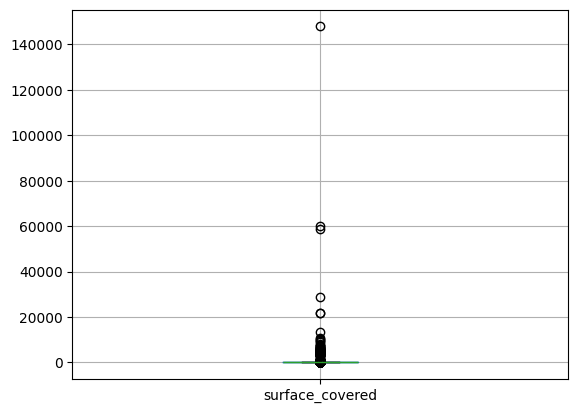

paga_comision
object
is_price_period_null
int64
Outliers detectados en is_price_period_null (IQR): 0 (0.00%)
Limite inferior: -1.5
Limite Superior: 2.5


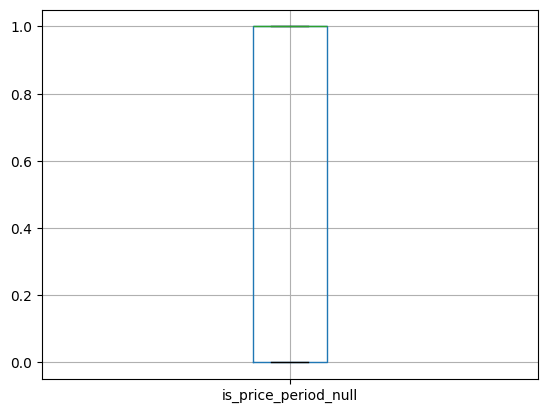

In [ ]:
for col in variables_a_utilizar:
    print(col)
    print(df_train[col].dtype)
    if df_train[col].dtype in ['int', 'float']:
        analizar_outliers(col)

Criterios para limpieza de outliers:  
- Rooms: valores mayores a 8.
- Bedrooms: valores mayores a 5.
- surface_total: valores mayores a 200.
- surface_covered: valores mayores a 180.

In [43]:
df_limpio = df_train.copy()

In [45]:
# Limpieza de outliers en df_limpio
df_limpio.loc[df_limpio['rooms'] > 7, 'rooms'] = np.nan
df_limpio.loc[df_limpio['bedrooms'] > 5, 'bedrooms'] = np.nan
df_limpio.loc[df_limpio['surface_total'] > 200, 'surface_total'] = np.nan
df_limpio.loc[df_limpio['surface_covered'] > 180, 'surface_covered'] = np.nan

# Analisis Multivariado

Se procede a realizar el analisis multivariable de los datos para buscar correlaciones existentes entre los mismos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer

## Matriz de Correlacion

Como era de esperarse, la correlacion entre las variables de superficie y las de tipos de cuartos en la propiedad poseen una alta correlacion entre ellas. Ademas, podemos observar que entre superficie y cuartos la correlacion es muy pequena, y que no existen variables con una correlacion negativa.

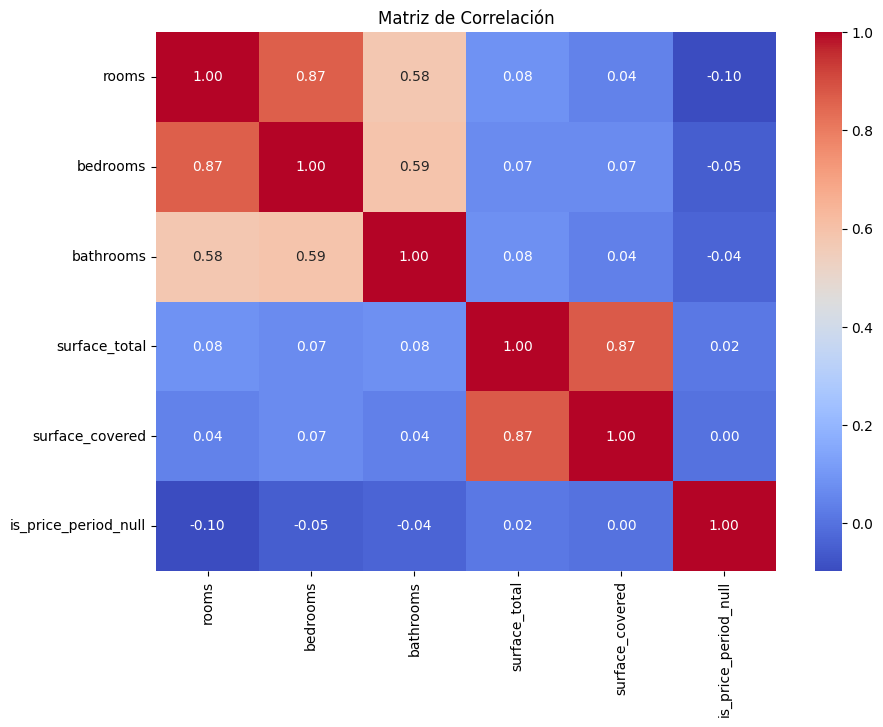

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
mat = df_train[variables_a_utilizar].select_dtypes(include=['int', 'float']).corr()
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f",  ax=ax)
plt.title('Matriz de Correlación')
plt.show()

In [ ]:
# Crear una versión numérica de paga_comision
df_train['paga_comision_numeric'] = (df_train['paga_comision'] == 'paga').astype(int)

# Ahora calcular correlaciones
df_train_corr = df_train[variables_a_utilizar + ['paga_comision_numeric']].select_dtypes(include=['int', 'float']).corr()[["paga_comision_numeric"]] * 100

df_train_corr = df_train_corr.drop("paga_comision_numeric", axis=0)
df_train_corr = abs(df_train_corr)
df_train_corr = df_train_corr.sort_values(["paga_comision_numeric"], ascending=False)
df_train_corr

,paga_comision_numeric
bathrooms,59.034643
rooms,44.156005
bedrooms,23.057084
is_price_period_null,7.558079
surface_total,7.213406
surface_covered,4.176674


Tanto bathrooms como rooms tienen una fuerte correlación con la variable target por sí mismas.  
A pesar de que las variables de superficie presentan una baja correlación lineal, creemos que combinadas con las variables geográficas pueden incrementar su poder predictivo, por lo cual seguirán en consideracion.  
Parece que surface_total tiene mayor correlacion con la variable target que surface_covered, descartamos surface_covered por ahora.

In [ ]:
# PCA

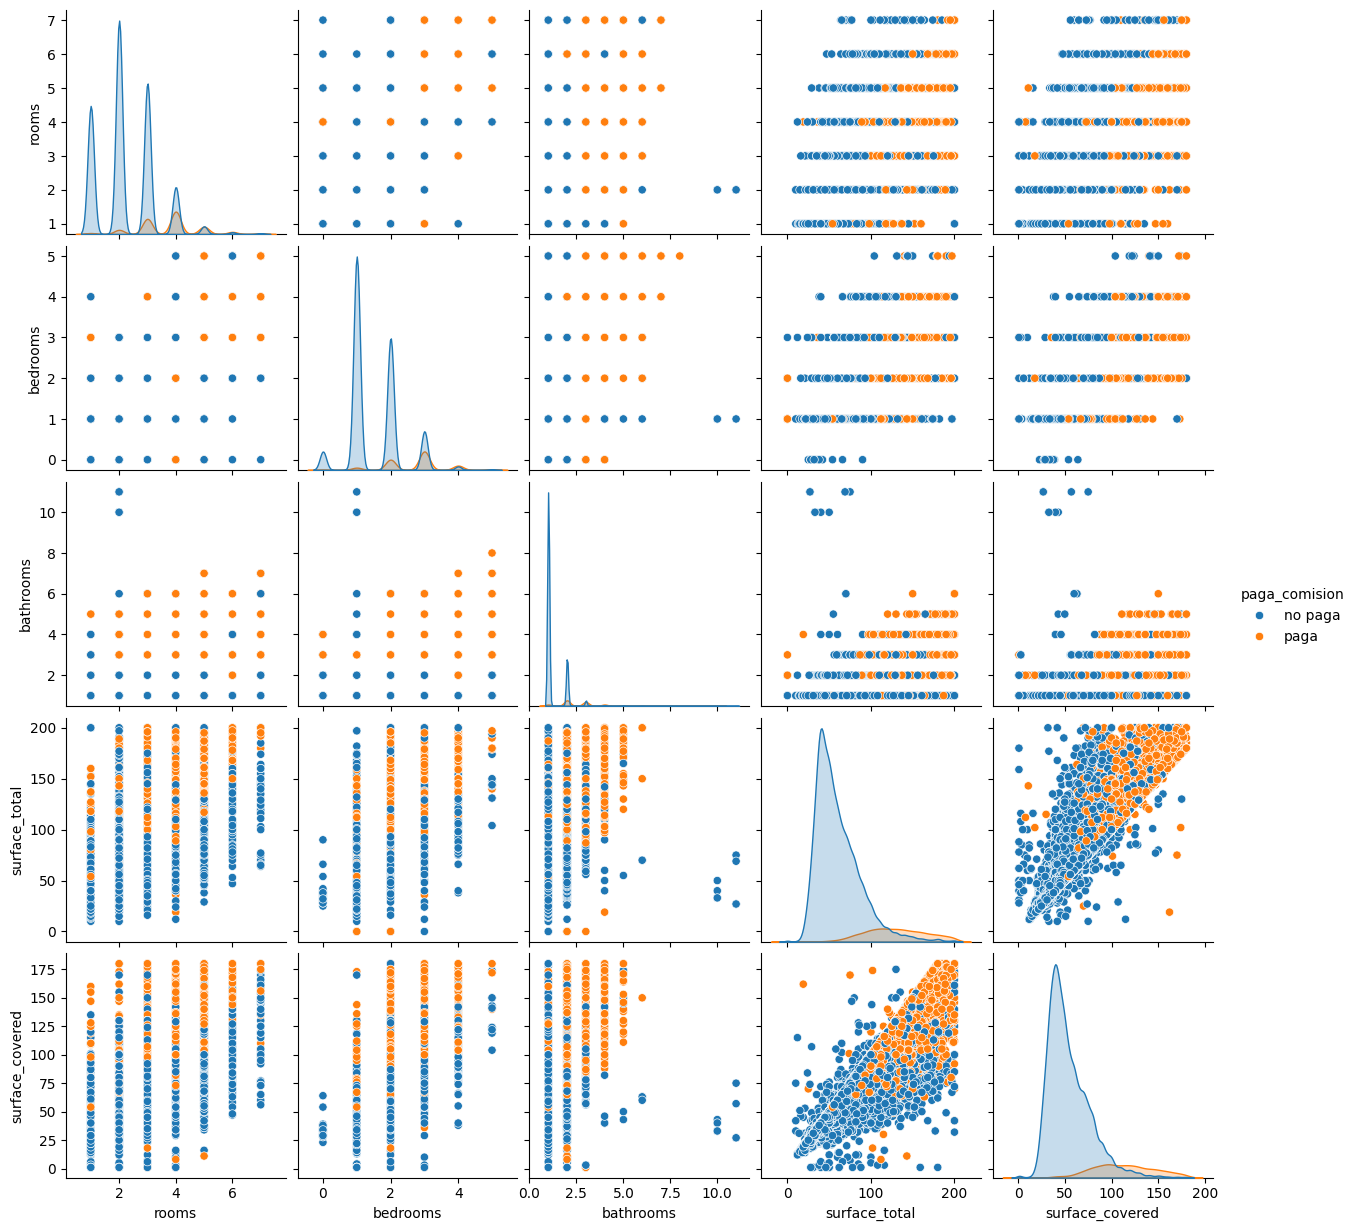

In [46]:
sns.pairplot(df_limpio[variables_a_utilizar_numericas],hue="paga_comision")

In [ ]:
##